# CH 8 Introduction to deep learningfor computer vision

了解卷積網路<br>
使用數據增強來減輕過擬合<br>
使用預訓練的捲積網絡做特徵萃取<br>
微調預訓練的捲積網絡<br>


計算機視覺是深度學習最早也是最大的成功案例。每天，您都在與深度視覺模型進行交互 通過谷歌照片、谷歌圖像搜索、YouTube、相機應用程序中的視頻過濾器、OCR軟件(圖片辨識文字)等等。這些模型也是自動駕駛、機器人、人工智能輔助醫療診斷、自動零售結賬系統甚至自動農業等前沿研究的核心。

計算機視覺是導致深度學習在 2011 年至 2015 年之間最初興起的問題領域。大約在那個時候，一種稱為卷積神經網絡的深度學習模型開始在圖像分類比賽中取得非常好的成績，首先是 Dan Ciresan 贏得了兩個利基市場比賽（ICDAR 2011 漢字識別比賽和 IJCNN 2011 德國交通標誌識別比賽），然後更引人注目的是在 2012 年秋季，Hinton 的團隊贏得了備受矚目的 ImageNet 大型視覺識別挑戰。許多更有希望的結果很快開始在其他計算機視覺任務中冒出來。


有趣的是，這些早期的成功還不足以讓深度學習成為當時的主流 它花了幾年時間。
計算機視覺研究社區多年來一直在投資於神經網絡以外的方法，並且還沒有準備好僅僅因為有一個新孩子就放棄它們。在 2013年和 2014 年，深度學習仍然面臨許多高級計算機視覺研究人員的強烈懷疑。直到 2016 年，它才最終佔據主導地位。我記得在2014 年 2 月曾勸告我的一位前教授轉向深度學習。“這是下一件大事！”我會說。“嗯，也許這只是一種時尚，做深度學習。沒有停止時間的想法”他回答。

本章介紹卷積神經網絡，也稱為卷積神經網絡，這是一種現在幾乎普遍用於計算機視覺應用的深度學習模型。你會學習將捲積網絡應用於圖像分類問題 尤其是那些涉及小型訓練數據集的問題，如果您不是大型科技公司，這是最常見的用例。


## 8.1 卷積網絡簡介

我們將深入探討什麼是卷積網絡以及為什麼它們在計算機視覺任務中如 此成功的理論。但首先，讓我們實際看一個簡單的捲積網絡示例，該示例 對 MNIST 數字進行分類，這是我們在第 2 章中使用密集連接網絡執行的任務（當時我們的測試準確率為 97.8%）。

儘管 convnet 是基本的，但它的準確性會讓我們在第 2 章中的密集連接模型徹底崩潰。

以下清單顯示了基本卷積網絡的外觀。它是一堆Conv2D和MaxPooling2D 層。你會在一分鐘內看到他們到底做了什麼。我們將使用上一章介紹的功能API 構建模型。

### 實例化一個小型卷積網路

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

Displaying the model's summary

In [2]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856 

您可以看到每個Conv2D和MaxPooling2D層的輸出都是形狀為(height, width, channels)的 rank‑3 張量。
隨著模型的深入，寬度和高度尺寸往往會縮小。通道數由傳遞給Conv2D層（32、64 或 128）的第一個參數(filter)控制。

在最後一個Conv2D層之後，我們最終得到一個形狀為(3, 3, 128)的輸出 一個 3 × 3 的 128 個通道的特徵圖。下一步是將此輸出輸入到您已經熟悉的密集連接分類器中：一堆密集層。

最後，我們進行 10 路分類，因此我們的最後一層有 10 個輸出和一個softmax 激活函數。

現在，讓我們在 MNIST 數字上訓練卷積網絡。我們將重用第 2 章中 MNIST 示例中的大量代碼。因為我們正在使用 softmax 輸出進行 10 路分類，所以我們將使用分類交叉熵損失，並且因為我們的標籤是整數，所以我們將使用稀疏版本sparse_categorical_crossentropy 。


### 8.3 在MNIST圖像上訓練卷積網路

In [3]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255
model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/5
938/938 [==============================] - 57s 60ms/step - loss: 0.1532 - accuracy: 0.9521
Epoch 2/5
938/938 [==============================] - 55s 59ms/step - loss: 0.0439 - accuracy: 0.9867
Epoch 3/5
938/938 [==============================] - 56s 60ms/step - loss: 0.0298 - accuracy: 0.9905
Epoch 4/5
938/938 [==============================] - 55s 58ms/step - loss: 0.0233 - accuracy: 0.9928
Epoch 5/5
938/938 [==============================] - 54s 58ms/step - loss: 0.0179 - accuracy: 0.9945


讓我們根據測試數據評估模型。

### 8.4 評估卷積網絡

In [4]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

313/313 [==============================] - 3s 11ms/step - loss: 0.0308 - accuracy: 0.9919
Test accuracy: 0.992


第 2 章中的密集連接模型的測試準確率為 97.8%，而基本卷積網絡的測試準確率為 99.1%：我們將錯誤率降低了約 60%（相對）。不錯！



但是，與密集連接的模型相比，為什麼這個簡單的 convnet 工作得這麼好呢？為了回答這個問題，讓我們深入了解Conv2D和MaxPooling2D 層的作用。

## 8.1.1 卷積操作

密集連接層和卷積層之間的根本區別在於：密集層在其輸入特徵空間中學習全局模式（例如，對於 MNIST 數字，涉及所有像素的模式），而卷積層學習局部模式 在這種情況下圖像，在輸入的小 2D 窗口中發現的模式（見圖 8.1）。在前面的示例中，這些窗口都是 3 × 3。

圖 8.1 圖像可以分解成局部圖案，例如邊緣、紋理等。

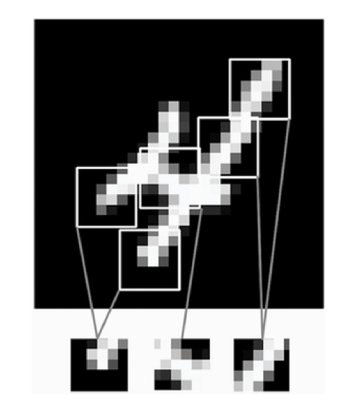

這個關鍵特性為卷積網絡提供了兩個有趣的屬性：


他們學習的模式是翻譯不變的。在學習了圖片右下角的
某種模式後，卷積神經網絡可以在任何地方識別它：例如， 在左上角。如果一個緊密連接的模型出現在一個新的位
置，它就必須重新學習該模式。這使得卷積網絡在處理圖像時數據高效（因為視覺世界從根本上來說是平移不變的）：它們需要更少的訓練樣本來學習具有泛化能力的表示。



他們可以學習模式的空間層次結構。第一個卷積層將學習小的局部模式，例如邊緣，第二個卷積層將學習由第
一層的特徵組成的更大的模式，依此類推（見圖 8.2）。
這使得 convnets 可以有效地學習越來越複雜和抽象的視覺


圖 8.2 視覺世界形成了視覺模塊的空間層次結構：基本的線條或紋理組合成簡單的對象，如眼睛或耳朵，它們組合成高級概念，如“貓”。

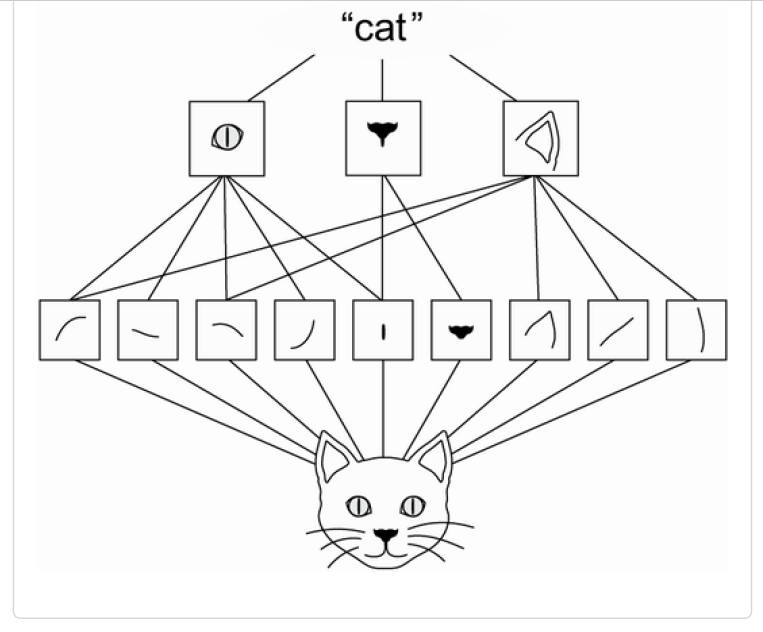

卷積在稱為特徵圖的 rank-3 張量上運行，具有兩個 ,空間軸（高度和寬度）以及一個深度軸(又稱為通道軸)。。對於 RGB 圖像，深度軸的維度為 3，因為圖像具有紅色、綠色和藍色三個顏色通道。對於黑白圖片，如 MNIST 數字，深度為 1（灰度級）。卷積操作從其輸入特徵圖中提取補丁，並對所有這些補丁應用相同的變換，生成輸出特徵圖。這個輸出特徵圖仍然是一個 rank‑3 張量：它有一個寬度和一個高度。它的深度可以是任意的，因為輸出深度是層的一個參數，並且該深度軸上的不同通道不再代表 RGB 輸入中的特定顏色；相反，它們代表過濾器。



過濾器對輸入數據的特定方面進行編碼：在高層次上，單個過濾器可以編碼輸入中存在人臉，
例如。在 MNIST 示例中，第一個卷積層採用大小為(28, 28, 1)的特徵圖並輸出大小為(26, 26, 32)的特徵圖：它在其輸入上計算 32 個過濾器。這 32 個輸出通道中的每一個都包含一個 26 × 26 的值網格，它是濾波器在輸入上的響應圖，表示該濾波器模式在輸入中不同位置的響應（見圖 8.3）。


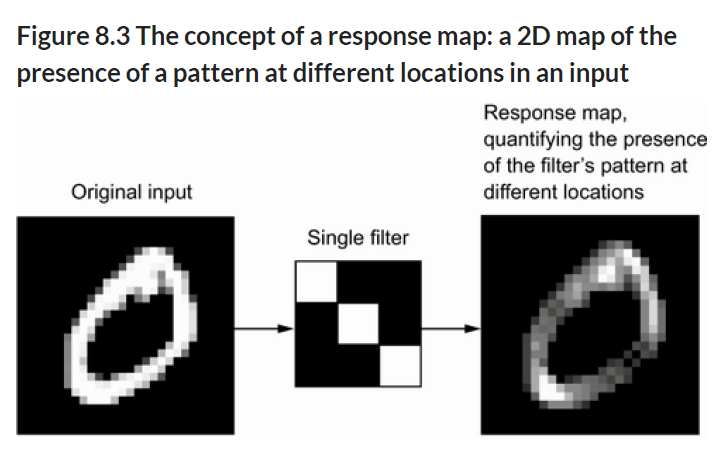

這就是術語特徵圖的含義：深度軸上的每個維度都是一個特徵（或過濾器），而 rank‑2 張量output[:, :,n]是該濾波器對輸入的響應的 2D 空間圖。

卷積由兩個關鍵參數定義：


從輸入中提取的補丁大小 通常是 3 × 3 或 5 × 5。在示例中， 它們是 3 × 3，這是一個常見的選擇。


輸出特徵圖的深度 這是卷積計算的濾波器數量。該示例以深度32 開始，以深度 128 結束。


在Keras Conv2D層中，這些參數是傳遞給層的第一個參數： Conv2D(output_depth, (window_height, window_width)) 。

卷積的工作原理是在 3D 輸入特徵圖上滑動這些大小為 3×3 或 5×5 的窗口，在每個可能的位置停止，然後提取周圍特徵的 3D 補丁形狀（window_height，window_width，input_depth） ）。然後將每個這樣的 3D 補丁轉換為 1D 形狀矢量，該矢量通過張量積與(output_depth,)學習的權重矩陣，稱為卷積核 

每個補丁都重複使用相同的核。然後將所有這些向量（每個補丁一個）在空間上重新組合成一個形狀為(height, width, output_depth)的 3D 輸出圖。輸出特徵圖中的每個空間位置都對應於輸入特徵圖中的相同位置（例如，輸出的右下角包含有關輸入右下角的信息）。例如， 對於 3 × 3 窗口，向量output[i, j, :]來自 3D 補丁input[i‑1:i+1, j‑1:j+1, :] 。圖 8.4 詳細說明了整個過程。

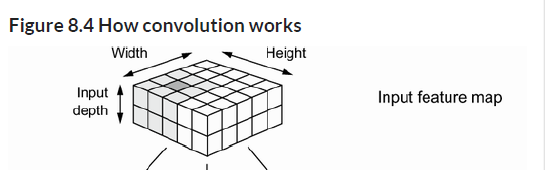

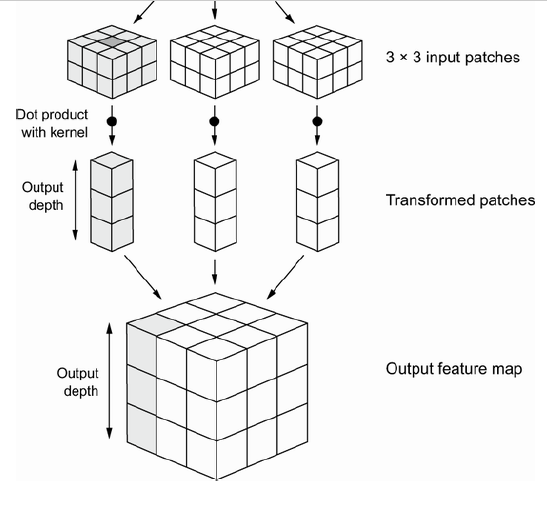

請注意，輸出寬度和高度可能與輸入寬度和高度不同，原因有兩個：<br>
padding：可以通過填充輸入特徵圖來抵銷<br>
stride：移動的步伐<br>

考慮一個 5 × 5 的特徵圖（總共 25 個圖塊）。只有 9 個圖塊可以圍繞其居中放置一個 3 × 3 的窗口，形成一個 3 × 3 的網格
（見圖 8.5）。因此，輸出特徵圖將是 3 × 3。
它縮小了一點：在這種情況下，每個維度旁邊正好有兩個瓷磚。你可以在前面看到這個邊框效果
示例：您從 28 × 28 輸入開始，在第一個卷積層之後變為 26 × 26。

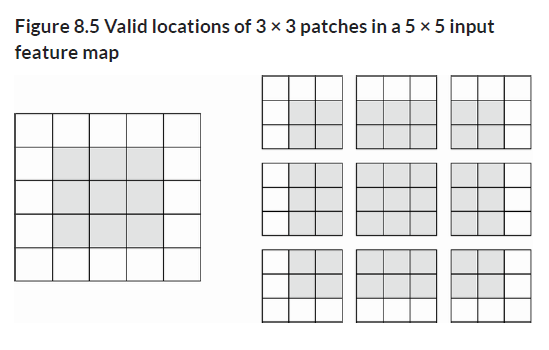

如果要獲得與輸入具有相同空間維度的輸出特徵圖，可以使用 填充。填充包括在輸入特徵圖的每一側添加適當數量的行和列， 以便可以在每個輸入圖塊周圍擬合中心卷積窗口。對於 3 × 3窗口，您在右側添加一列，在右側添加一列左，上一排，下一排。對於 5 × 5 窗口，添加兩行（見圖 8.6）。


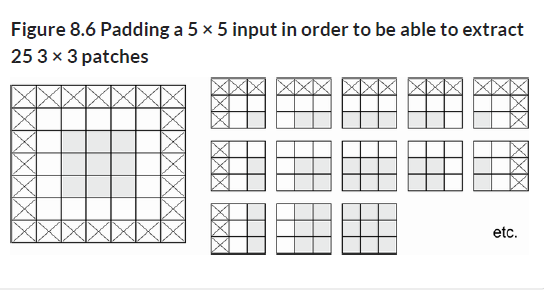

在Conv2D層中，填充可通過填充配置參數，它有兩個值：“有效”，表示沒有,填充（僅使用有效的窗口位置），以及“相同的”, 這意味著“以具有輸出的方式填充具有與輸入相同的寬度和高度。”填充參數默認為“有效”

了解stride

可以影響輸出大小的另一個因素是步幅的概念。到目前為止，我們對卷積的描述假設卷積窗口的中心塊都是連續的。


但是兩個連續窗口之間的距離是卷積的一個參數，稱為它的步幅， 默認為 1。可能有步幅卷積：步幅大於 1 的捲積。在圖 8.7 中，您可以看到由3 × 3 卷積，步幅為 2，輸入為 5 × 5（無填充）。


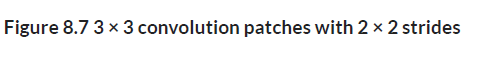

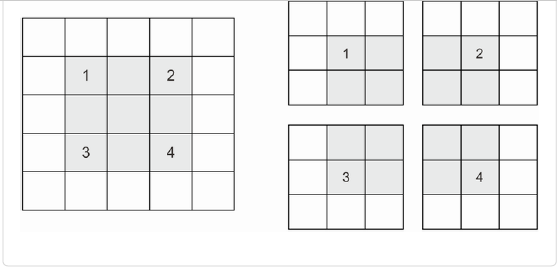

使用步幅 2 意味著特徵圖的寬度和高度被下採樣 2 倍（除了邊界效應引起的任何變化）。跨步卷積很少在分類模型中使用，但它們對於某些類型的模型非常有用，正如您將在下一章中看到的那樣。



在分類模型中，我們傾向於使用最大池化操作來對特徵圖進行下採樣，而不是stride
 
Machine Translated by G在oogle我們的第一個 convnet 示例中看到了。讓我們更深入地看看它。

## 8.1.2	最大池化操作

在 convnet 示例中，您可能已經註意到，在每個MaxPooling2D層之後， 特徵圖的大小減半。例如，在第一個MaxPooling2D層之前，特徵圖為 26
× 26，但最大池化操作將其減半為 13 × 13。


這就是最大池化的作用：積極地對特徵圖進行下採樣，就像跨步卷積一樣。


最大池包括從輸入特徵圖中提取窗口並輸出每個通道的最大值。它在概念上類似於卷積，除了不是通過學習的線性變換（卷積核）來變換局部塊，而是通過硬編碼的最大張量操作來變換它們。與卷積的一個很大區別是，最大池化通常使用 2 × 2 窗口和步長 2 完成，以便將特徵圖下採樣 2 倍。


一方面，卷積通常使用 3 × 3 窗口且沒有步幅（步幅 1）完成。


為什麼要以這種方式下採樣特徵圖？為什麼不移除最大池化層並一直保持相當大的特徵圖呢？讓我們看看這個選項。我們的模型將如下所示。


### 8.5 一個結構不正確的捲積網絡缺少最大池化層

In [5]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model_no_max_pool = keras.Model(inputs=inputs, outputs=outputs)

In [6]:
model_no_max_pool.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 128)       73856     
                                                                 
 flatten_1 (Flatten)         (None, 61952)             0         
                                                                 
 dense_1 (Dense)             (None, 10)                619530    
                                                                 
Total params: 712,202
Trainable params: 712,202
Non-trainab

這個設置有什麼問題？兩件事情：

它不利於學習特徵的空間層次結構。第三層的 3 × 3 窗口 將僅包含來自初始輸入中 7 × 7 窗口的信息。相對於初始輸
入，卷積網絡學習的高級模式仍然非常小，這可能不足以學習
對數字進行分類（嘗試通過僅通過 7 × 7 像素的窗口查看數字來識別數字！ ）。我們需要來自最後一個卷積層的特徵來包含有關輸入整體的信息。

最終的特徵圖每個樣本有 22 × 22 × 128 = 61,952 個總係數。這是巨大的。當您將其展平以在頂部粘貼一個大小為 10 的Dense層時，該層將具有超過 50 萬個參數。這對於如此小的模型來說太大了，並且會導致嚴重的過度擬合。


簡而言之，使用下採樣的原因是為了減少要處理的特徵映射
係數的數量，以及通過使連續的捲積層查看越來越大的窗口來誘導空間濾波器層次結構（就原始輸入的比例而言）他們覆蓋）。

請注意，最大池化並不是實現這種下採樣的唯一方法。如您所知，您還可以在先前的捲積層中使用步幅。您可以使用平均池而不是最大池，其中每個本地輸入補丁通過取補丁上每個通道的平均值而不是最大值來轉換。但是最大池化往往比這些替代解決方案效果更好。原因是特徵傾向於在特徵圖的不同圖塊上對某些模式或概念的空間存在進行編碼（因此稱為特徵圖），並且查看不同特徵的最大存在比查看它們的平均存在更能提供信息.最合理的子採樣策略是首先生成特徵的密集映射（通過未跨步的捲積），然後在小範圍內查看特徵的最大激活補丁，而不是查看輸入的稀疏窗口（通過跨步卷積）或平均輸入補丁，這可能會導致您錯過或稀釋特徵存在信息。



此時，您應該了解卷積網絡的基礎知識 特徵圖、卷積和最大池化 並且應該知道如何構建一個小型捲積網絡來解決諸如MNIST 數字分類之類的玩具問題。現在讓我們繼續討論更有用、更實際的應用程序。

## 8.2	在小數據集上從零開始訓練卷積網絡

必須使用很少的數據來訓練圖像分類模型是一種常見情況，如果您曾經在專業環境中進行計算機視覺，您可能會在實踐中遇到這種情況。
“少數”樣本可能意味著幾百到幾萬張圖像。作為一個實際示例，
我們將專注於在數據集中將圖像分類為狗或貓包含5,000張貓和狗的照片（2,500 隻貓，2,500 隻狗）。我們將使用 2,000 張圖片進行訓練，1,000 張圖片用於驗證，2,000 張圖片用於測試。



在本節中，我們將回顧解決此問題的一種基本策略：使用您擁有的少量數據從頭開始訓練新模型。我們將首先在 2,000 個訓練樣本上
天真地訓練一個小型捲積網絡，不進行任何正則化，為可以實現的目標設置基線。這將使我們的分類準確率達到 70% 左右。那時，主要問題將是過度擬合。然後我們將介紹數據增強，這是一種減輕計算機視覺過度擬合的強大技術。通過使用數據增強，我們將改進模型以達到 80‑85% 的準確度。


在下一節中，我們將回顧兩種將深度學習應用於小型數據集的基本技術：使用預訓練模型進行特徵提取（這將使我們達到 97.5% 的準確度） 和微調預訓練模型（這將獲得我們的最終準確率為 98.5%）。這三種策略加在一起


## 8.2.1	深度學習對小數據問題的相關性

有資格訓練模型的“足夠樣本”是相對的 對於初學者來說，相對於您嘗試訓練的模型的大小和深度。僅僅用幾十個樣本來訓 練一個卷積網絡來解決一個複雜的問題是不可能的，但是如果 模型很小並且正則化並且任務很簡單，那麼幾百個就足夠了。因為卷積網絡學習本地的、翻譯不變的特徵，所以它們在感知問題上具有很高的數據效率。儘管數據相對缺乏，但在非常小的圖像數據集上從頭開始訓練卷積網絡將產生合理的結果，而無需任何自定義特徵工程。您將在本節中看到這一點。

更重要的是，深度學習模型本質上是高度可重複利用的：例如，您可以採用在大規模數據集上訓練的圖像分類或語音到文本模型，並將其重用於一個顯著不同的問題，只需進行微小的更改。

具體來說，在計算機視覺的情況下，許多預訓練模型（通常在 ImageNet 數據集上訓練）現在可以公開下載，並可用於從非常少的數據中引導強大的視覺模型。這是深度學習的最大優勢之一：特徵重用。您將在下一節中探討這一點。


讓我們從掌握數據開始。

## 8.2.2	下載數據

我們將使用的 Dogs vs. Cats 數據集沒有與 Keras 打包。它是由 Kaggle 在 2013 年底作為計算機視覺競賽的一部分提供的，當時卷積網絡還不是主流。您可以從www.kaggle.com/c/dogs‑vs‑cats/data下載原始數據集，您還可以使用Kaggle API 在 Colab 中下載數據集（請參閱“在 Google Colaboratory 中下載 Kaggle 數據集”側邊欄）。


Kaggle 提供了一個易於使用的 API，用於以編程方式
下載 Kaggle 託管的數據集。例如，您可以使用它將 Dogs vs. Cats 數據集下載到 Colab 筆記本中。該 API 以kaggle包的形式提供，該包預安裝在 Colab 上。下載此數據集就像在 Colab 單元中運行以下命令一樣簡單：

但是，API 的訪問權限僅限於 Kaggle 用戶，因此要運行上述命令，您首先需要對自己進行身份驗證。 kaggle包將在位於 ~/.kaggle/ kaggle.json 的 JSON 文件中查找您的登錄憑據。讓我們創建這個文件。

首先，您需要創建一個 Kaggle API 密鑰並將其下載到您的本地計算機。只需在網絡瀏覽器中導航到 Kaggle 網站，登錄，然後轉到“我的帳戶”頁面。在您的帳戶設置中，您會找到一個 API 部分。單擊 Create New API Token 按鈕將生成一個 kaggle.json 密鑰文件並將其下載到您的機器上。


其次，轉到您的 Colab 筆記本，並上傳 API 的密鑰
通過在筆記本單元格中運行以下代碼，將 JSON 文件添加到Colab 會話：


In [ ]:
#上傳kaggle密鑰(json檔)
from google.colab import files
files.upload()

當你運行這個單元格時，你會看到一個選擇文件按鈕出現。單擊它並選擇您剛剛下載的 kaggle.json 文件。這會將文件上傳到本地Colab 運行時。


最後，創建一個 ~/.kaggle 文件夾（ mkdir ~/.kaggle ），並將密鑰
文件複製到其中（ cp kaggle.json ~/.kaggle/ ）。作為安全最佳實踐， 您還應該確保該文件只能由當前用戶自己讀取（ chmod 600 ）：


In [15]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

您現在可以下載我們將要使用的數據：

In [20]:
#下載kaggle檔案
!kaggle competitions download --force -c dogs-vs-cats

 99% 806M/812M [00:04<00:00, 240MB/s]
100% 812M/812M [00:04<00:00, 193MB/s]


第一次嘗試下載數據時，您可能會收到“403 Forbidden”錯誤。那是因為你需要在下載數據集之前接受與數據集相關的條款 你必須去
www.kaggle.com/c/dogs‑vs cats/rules （登錄到你的 Kaggle 賬戶時）並點擊 I理解並接受按鈕。你只需要這樣做一次。

最後，訓練數據是一個名為 train.zip 的壓縮文件。確保您以靜默方式解壓縮 ( unzip ) ( ‑ qq )：


In [29]:
!unzip -qq dogs-vs-cats.zip

replace sampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test1.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [30]:
!unzip -qq train.zip

我們數據集中的圖片是中等分辨率的彩色 JPEG。圖 8.8 顯示了一些示例。

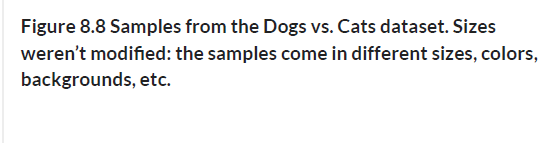

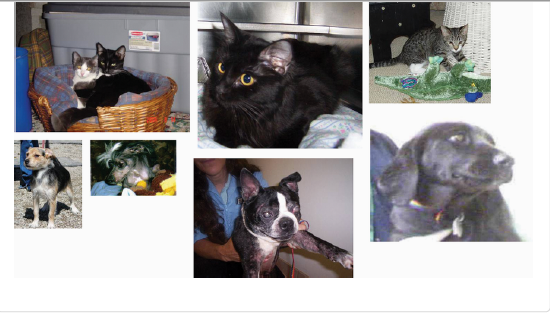

不出所料，早在 2013 年，最初的狗對貓 Kaggle 比賽就是由使
用卷積網絡的參賽者贏得的。最佳條目的準確率高達 95%。在這個例子中， 我們將非常接近這個準確度（在下一節中），儘管我們將在不到 10% 的競爭對手可用數據上訓練我們的模型。


該數據集包含 25,000 張狗和貓的圖像（每個類別 12,500 張），
大小為 543 MB（壓縮後）。下載並解壓縮數據後，我們將創建一個包含三個子集的新數據集：每個類別包含 1,000 個樣本的訓練集、每個類別包含 500 個樣本的驗證集和每個類別包含 1,000 個樣本的測試集。為什麼要這樣做？因為你在職業生涯中會遇到的許多圖像數據集 只包含幾千個樣本，而不是幾萬個。擁有更多可用數據將使問題變得 更容易，因此使用小型數據集進行學習是一種很好的做法。


我們將使用的子採樣數據集將具有以下目錄結構：

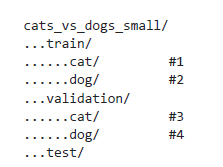

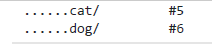

讓我們通過幾次調用shutil來實現它

### 8.6 將圖像複製到訓練、驗證和測試目錄

In [31]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

我們現在有 2,000 個訓練圖像、1,000 個驗證圖像和 2,000 個測試圖像。每個拆分包含來自每個類別的相同數量的樣本：這是一個平衡的二元分類問題，這意味著分類準確度將是衡量成功的適當指標。

## 8.2.3 構建模型

我們將重用您在第一個示例中看到的相同的通用模型結構：convnet 將是交替的Conv2D （具有relu激活）和MaxPooling2D層的堆棧。

但是因為我們正在處理更大的圖像和更複雜的問題，我們將相應地使
我們的模型更大：它將有兩個更多的 Conv2D和MaxPooling2D階段。這既可以增加模型的容量，又可以進一步減小特徵圖的大小，因此當我們到達Flatten層時它們不會過大。在這裡，因為我們從大小為 180 像素 × 180 像素的輸入開始（有點隨意的選擇），我們最終在Flatten層之前得到大小為 7 × 7 的特徵圖。


模型中特徵圖的深度逐漸增加（從 32 到 256），而特徵圖的大小減小
（從 180 × 180 到 7 × 7）。這是您將在幾乎所有的捲積網絡中看到的模式。


因為我們正在研究一個二元分類問題，所以我們將以單個單元（大小為 1 的Dense層）和一個sigmoid激活。該單元將編碼模型正在查看一類或另一類的概率。

最後一個小區別：我們將以重新縮放層，它將圖像輸入（其值最初在 [0, 255] 範圍內）重新縮放到 [0, 1] 範圍。

### 8.7 為狗與貓分類實例化一個小型捲積網絡

In [32]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [33]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                       

對於編譯步驟，我們將像往常一樣使用RMSprop優化器。因為我們以單個
sigmoid 單元結束了模型，所以我們將使用二元交叉熵作為損失（提醒一下，請查看第 6 章中的表 6.1 以了解在各種情況下使用哪種損失函數的備忘單）。


###  8.8 為訓練配置模型

In [34]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

## 8.2.4	數據預處理

正如您現在所知道的，在將數據輸入模型之前，應該將數據格式化為經過適當預處理的浮點張量。目前，數據以 JPEG 格式保存在驅動器上，因此將其導入模型的步驟大致如下：

1.	閱讀圖片文件。
2.	將 JPEG 內容解碼為 RGB 像素網格。
3.	將這些轉換為浮點張量。
4.	將它們調整為共享大小（我們將使用 180 × 180）。
5.	將它們打包成批次（我們將使用 32 張圖像的批次）。


這可能看起來有點令人生畏，但幸運的是 Keras 有實用程序可以自動處理這些步驟。特別是，Keras 具有實用功能image_dataset_from_ ，它可以讓您快速設置一個數據管道， directory()可以自動將磁盤上的圖像文件轉換成
, 批量預處理的張量。這就是我們將在這裡使用的。


調用image_dataset_from_directory(directory)將首先列出目錄的子目錄，並假設每個子目錄都包含來自我們某個類的圖像。然後它將索引每個子目錄中的圖像文件。最後，它會創建並返回一個tf.data.Dataset對象，配置為讀取這些文件，將它們打亂，將它們解碼為張量，將它們調整為共享大小，並將它們打包成批次。

### 8.9 使用 image_dataset_from_directory 讀取圖像

In [35]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


理解 TensorFlow 數據集對象
TensorFlow 提供了tf.data API 來創建機器學習模型的有效輸入管道。它的核心類是tf.data.Dataset.Dataset對像是一個迭代器：您可以在for循環中使用它。它通常會返回成批的輸入數據和標籤。
您可以將Dataset對象直接傳遞給 Keras 模型的fit()方法。

Dataset類處理許多關鍵特性，否則這些特性很難自己實現 特別是異步數據預取（在模型處理前一批數據的同時預處理下一批數據，從而保持執行 流暢而不會中斷） 。

Dataset類還公開了一個函數式 API，用於
修改數據集。這是一個簡單的例子：讓我們創建一個來自 NumPy 隨機數數組的數據集實例。
我們將考慮 1,000 個樣本，其中每個樣本都是一個向量尺寸 16：


In [36]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

起初，我們的數據集只產生單個樣本：

In [37]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


我們可以使用.batch()方法對數據進行批處理：

In [38]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


更廣泛地說，我們可以訪問一系列有用的數據集方法，例如

.shuffle(buffer_size)	隨機播放元素在緩衝區內

.prefetch(buffer_size)	預取緩衝區
GPU 內存中的元素，以實現更好的設備利用率。

.map(callable)	對數據集的每個元素應用任意變換 
（作為數據集產生的單個元素, 預計採取的輸入可調用的函數）。

 
特別是.map()方法是您經常使用的方法。
這是一個例子。我們將使用它來將我們的玩具數據集中的元素從形狀(16,)重塑為形狀(4, 4) ：


In [41]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


你將在本章中看到更多的map()動作。

讓我們看一下其中一個Dataset對象的輸出：它產生一批 180 × 180
RGB 圖像（形狀(32, 180, 180, 3) ）和整數標籤（形狀(32,) ）。每批有 32 個樣本（批量大小）。

### 8.10 顯示數據集產生的數據和標籤的形狀

In [42]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)
data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


讓我們將模型擬合到我們的數據集上。我們將使用fit()中的validation_data參數用於監控單獨數據集對像上的驗證指標。

請注意，我們還將在每個 epoch 之後使用ModelCheckpoint回調來保存模型。我們將使用指定文件保存位置的路徑以及參數save_best_only=True 和monitor= val_loss	對其進行配置：它們告訴
 
Machine Translated by G當ooglve  al_loss指標的當前值低於訓練期間的任何先前時間時，回調僅保存一 個新文件（覆蓋任何先前的文件） 。這保證了您保存的文件將始終包含與其最佳訓練時期相對應的模型狀態，就其在驗證數據上的性能而言。因此， 如果我們開始過度擬合，我們不必為更少的 epoch 重新訓練一個新模型： 我們可以重新加載我們保存的文件。


### 8.11 使用數據集擬合模型

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 160s 3s/step - loss: 0.7451 - accuracy: 0.5275 - val_loss: 0.6921 - val_accuracy: 0.5040
Epoch 2/30
63/63 [==============================] - 161s 3s/step - loss: 0.6943 - accuracy: 0.5585 - val_loss: 0.6808 - val_accuracy: 0.5250
Epoch 3/30
63/63 [==============================] - 156s 2s/step - loss: 0.6915 - accuracy: 0.6025 - val_loss: 0.5998 - val_accuracy: 0.6820
Epoch 4/30
63/63 [==============================] - 157s 2s/step - loss: 0.6100 - accuracy: 0.6730 - val_loss: 0.6332 - val_accuracy: 0.6300
Epoch 5/30
63/63 [==============================] - 161s 3s/step - loss: 0.5868 - accuracy: 0.7045 - val_loss: 0.5721 - val_accuracy: 0.6910
Epoch 6/30
63/63 [==============================] - 157s 2s/step - loss: 0.5439 - accuracy: 0.7210 - val_loss: 0.6093 - val_accuracy: 0.6720
Epoch 7/30
63/63 [==============================] - 156s 2s/step - loss: 0.5362 - accuracy: 0.7325 - val_loss: 0.9283 - val_accuracy: 0.6010
Epoch 8/30
63

### 8.12 在訓練期間顯示損失和準確率曲線

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

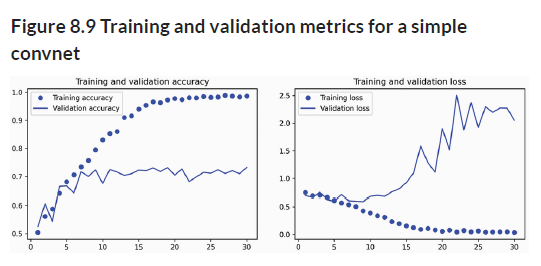

這些圖是過擬合的特徵。訓練準確度隨時間線性增加，直到接近100%，而驗證準確度達到 75% 的峰值。驗證損失僅在 10 個 epoch後達到最小值，然後停止，而訓練損失隨著訓練的進行而線性減少。

讓我們檢查一下測試的準確性。我們將從其保存的文件中重新加載模型，以評估它在開始過度擬合之前的狀態。


### 8.13 在測試集上評估模型

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

我們得到了 69.5% 的測試準確率。 （由於神經網絡初始化的隨機
性，你可能會得到一個百分點內的數字。）

因為我們的訓練樣本相對較少（2,000 個），所以過度擬合將是我們的首要關注點。您已經了解了許多有助於緩解過度擬合的技術，例如
dropout 和權重衰減（L2 正則化）。我們現在將使用一種新的，專門用於計算機視覺，並且在使用深度學習模型處理圖像時幾乎普遍使用：數據增強。


## 8.2.5	使用數據增強

過度擬合是由於可供學習的樣本太少，導致您無法訓練可以泛化到新數 據的模型。給定無限數據，您的模型將暴露於手頭數據分佈的每個可能方面：您永遠不會過度擬合。數據增強採用從現有訓練樣本中生成更多訓練數據的方法通過一些隨機變換來增加樣本，產生看起來可信的圖像。
目標是，在訓練時，您的模型將永遠不會看到完全相同的圖片兩次。這有助於將模型暴露給數據的更多方面，以便更好地泛化。

在 Keras 中，這可以通過在模型的開頭添加許多數據增強層來完成。讓我們從一個示例開始：以下 Sequential 模型鏈接了幾個隨機圖像轉換。在我們的模型中，我們將它包含在Rescaling層之前。


### 8.14 定義一個數據增強階段以添加到圖像模型中

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

這些只是可用層中的一小部分（有關更多信息，請參閱 Keras 文檔）。讓我們快速瀏覽一下這段代碼：


RandomFlip( horizontal )	對通過它的隨機 50% 的圖像應用水平翻轉


RandomRotation(0.1) ‑ 以 [–10%, +10%] 範圍內的隨機值旋轉輸入圖像（這些是完整圓的分數 ‑ 以度為單位，範圍為 [–36 度，+36 度] )


RandomZoom(0.2)	以 [‑20%, +20%] 範圍內的隨機因子放大或縮小圖像

讓我們看一下增強後的圖像（見圖 8.10）。


### 8.15 顯示一些隨機增強的訓練圖片


In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

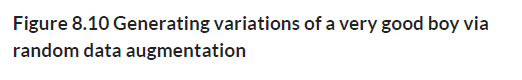

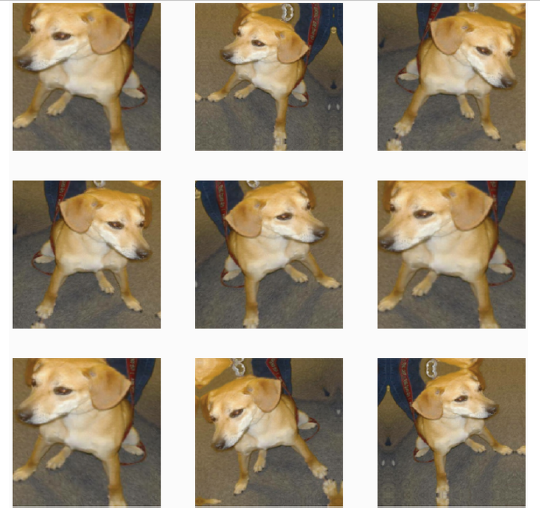

如果我們使用這種數據增強配置訓練一個新模型，該模型將永
遠不會看到相同的輸入兩次。但是它看到的輸入仍然是高度相關的，因為它 們來自少量的原始圖像 我們不能產生新的信息；我們只能重新混合現有信息。因此，這可能不足以完全擺脫過度擬合。為了進一步對抗過度擬合，我們還將在密集連接分類器之前的模型中添加一個Dropout層。


關於隨機圖像增強層你應該知道的最後一件事：就像Dropout
一樣，它們在推理期間是不活動的（當我們調用epvraelduiactte()(或)時）。在評估期間，我們的模型的行為與不包括數據增強和丟失時的行為相同。


### 8.16 定義一個包含圖像增強和 dropout 的新 convnet

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

讓我們使用數據增強和 dropout 來訓練模型。
因為我們預計過擬合會在訓練期間發生得更晚，所以我們將訓練三倍的 epoch 一百個。


### 8.17 訓練正則化卷積網絡

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

讓我們再次繪製結果：見圖 8.11。由於數據增強和丟失，我們開始
過擬合很晚，大約在 60‑70 時期（與原始模型的 10 時期相比）。驗證準確度始終保持在 80‑85% 的範圍內 與我們的第一次嘗試相比有了很大的改進。


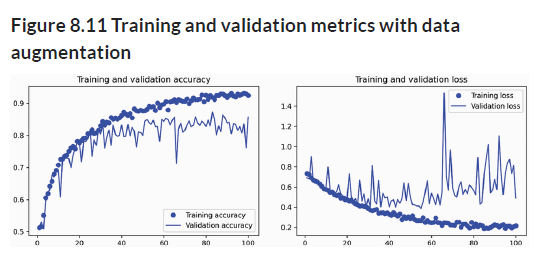

讓我們檢查一下測試的準確性。

### 8.18 在測試集上評估模型

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

我們得到了 83.5% 的測試準確率。它開始看起來不錯！如果您使用的是 Colab，請確保下載保存的文件(convnet_from_scratch_with_augmentation.keras)，因為我們將在
下一章中使用它進行一些實驗。

通過進一步調整模型的配置（例如每個卷積層的過濾器數量，或模型中的層數），我們可能能夠獲得更好的準確率，可能高達 90%。但事實證明，僅僅通過從頭開始訓練我們自己的捲積神經網絡很難走得更高，因為我們幾乎沒有要處理的數據。作為提高我們在這個問題上的準確性的下一步，我們將不得不使用預訓練模型，這是接下來兩節的重點。


8.3	利用預訓練模型
在小型圖像數據集上進行深度學習的一種常見且高效的方法是使用預訓 練模型。預訓練模型是以前在大型數據集上訓練過的模型，通常是在大規模圖像分類任務上。如果這個原始數據集足夠大且足夠通用，則預訓練模型學習到的特徵空間層次結構可以有效地充當視覺世界的通用模型，因此，它 的特徵可以證明對許多不同的計算機視覺問題有用，即使這些新問題可能涉及與原始任務完全不同的類別。例如，您可以在 ImageNet 上訓練一個模型（其中類主要是動物和日常物品），然後將這個訓練過的模型重新用於識別圖像中的家具物品等遠程任務。學習特徵的這種可移植性與許多舊的淺層學習方法相比，跨越不同問題是深度學習的一個關鍵優 勢，它使深度學習對於小數據問題非常有效。


在這種情況下，讓我們考慮一個在 ImageNet 數據集（140 萬個標
記圖像和 1000 個不同類別）上訓練的大型捲積網絡。 ImageNet 包含許多動物類別，包括不同種類的貓和狗，因此您可以期望它在狗與貓分類問題上表現良好。


我們將使用由 Karen Simonyan 開發的 VGG16 架構和 2014 年的安德魯齊瑟曼。前的技術水平相去甚遠，並且比

1 雖然它是一個較舊的模型，但與當時許多其他最近的模型，我選擇它是因為它的架構與您已經熟悉的架構相似， 並且無需引入任何新概念即可輕鬆理解。這可能是你第一次遇到這些可愛的模型名稱 VGG、ResNet、Inception、Xception 等等；你會習慣它們， 因為如果你繼續為計算機視覺進行深度學習，它們會經常出現。

1 Karen Simonyan 和 Andrew Zisserman，“用於大規模圖像識別的非常深的捲積網絡，arXiv (2014)， https://arxiv.org/abs/1409.1556。

使用預訓練模型有兩種方法：特徵提取和微調。我們將介紹它們。讓我們從特徵提取開始。


## 8.3.1	使用預訓練模型進行特徵提取

特徵提取包括使用先前訓練的模型學習的表示從新樣本中提取有趣的特徵。然後這些特徵通過一個新的分類器運行，該分類器是從頭開始訓練的。

如您之前所見，用於圖像分類的捲積網絡包括兩部分：它們以一系列池化和卷積層開始，以密集連接層結束分類器。第一部分稱為模型的捲積基。在卷積網絡的情況下，
特徵提取包括獲取先前訓練的網絡的捲積基礎，通過它運行新數據，並在輸出之上訓練一個新的分類器（見圖 8.12）。


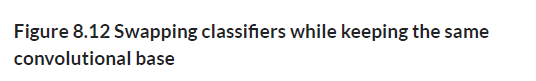

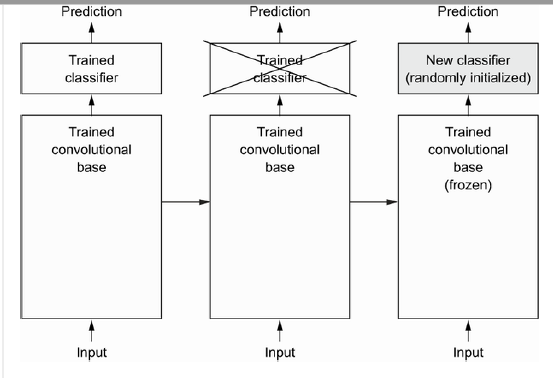

為什麼只重用卷積基？我們也可以重用密集連接的分類器嗎？一般來說，應該避免這樣做。原因是卷積基學習的表示可能更通用，因此，更可重用：卷積網絡的特徵圖是圖片上通用概念的存在圖，無論手頭的計算機視覺問題如何，它都可能有用。但是分類器學習的表示必然特定於訓練模型的類集 它們只包含關於整個圖片中這個或那個類的存在概率的信息。


此外，在密集連接層中發現的表示不再包含有關對像在輸入圖像中的位置的任何信息；這些層擺脫了空間的概念，而對象位置仍然由卷積特徵圖描述。對於對象位置很重要的問題，密集連接的特徵在很大程度上是無用的。

請注意，特定卷積層提取的表示的通用性（以及因此可重用性） 的水平取決於模型中層的深度。模型中較早出現的層提取局部、高度通用的特徵圖（例如視覺邊緣、顏色和紋理），而較高層提取更抽象的概念（例如“貓耳”或“狗眼”）。因此，如果您的新數據集與訓練原始模型的數據集有很大不同，您最好只使用模型的前幾層來進行特徵提取，而不是使用整個卷積基礎。


在這種情況下，由於 ImageNet 類集包含多個狗和貓類，因此重用原始模型的密集連接層中包含的信息可能是有益的。但是我們會選擇不這樣做， 以涵蓋更一般的情況，即新問題的類集不與原始模型的類集重疊。讓我們通過使用在 ImageNet 上訓練的 VGG16 網絡的捲積基礎將其付諸實
踐，從貓和狗圖像中提取有趣的特徵，然後在這些特徵之上訓練狗對貓分
類器。



除其他外，VGG16 模型與 Keras 一起預先打包。您可以從 keras.applications模塊導入它。
 
Machine Translated by Google
許多其他圖像分類模型（都在 ImageNet 數據集上預訓練）可作為keras.applications的
一部分使用：


異常 
資源網
移動網絡
高效網絡
密集網等等


讓我們實例化 VGG16 模型。



### 8.19 實例化 VGG16 卷積基

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

我們將三個參數傳遞給構造函數：


weights指定初始化模型的權重檢查點。


include_top是指在網絡頂部包含（或不包含）密集連接的分類器。默認情況下，這個密集連接的分類器對應於 ImageNet 中的 1000 個類。因為我們打算使用我們自己的密集連接分類器（只有兩個類：
cat和dog ），所以我們不需要包含它。 input_shape是我們將提供給網絡的圖像張量的形狀。這個參數完全是可選的：如果我們不傳遞它， 網絡將能夠處理任何大小的輸入。在這裡我們傳遞它，以便我們可以可視化（在下面的摘要中）特徵圖的大小如何隨著每個新的捲積和池化層而縮小。


這是 VGG16 卷積的架構的詳細信息
根據。它類似於您已經熟悉的簡單卷積網絡


In [ ]:
conv_base.summary()

最終的特徵圖具有形狀(5, 5, 512) 。這就是特徵圖，我們將在其上粘貼
一個密集連接的分類器。

在這一點上，我們可以採取兩種方式：
在我們的數據集上運行卷積基，將其輸出記錄到磁盤上的NumPy 數組中，然後將此數據用作獨立的、密集連接的分類器的輸入，類似於您在本書第 4 章中看到的分類器。這個解決方案運行起來又快又便宜，因為它只需要為每個輸入圖像運行一次卷積基，而卷積基是管道中迄今為止最昂貴的部分。但出於同樣的原 因，這種技術不允許我們使用數據增強。

通過在頂部添加Dense層來擴展我們擁有的模型
（ conv_base ） ，並在輸入數據上從頭到尾運行整個事情。這將允許我們使用數據增強，因為每個輸入圖像都經過模型每次看到的捲積基數。但出於同樣的原因，這種技術比第一種技術要昂貴得多。


我們將介紹這兩種技術。讓我們看一下設置第一個代碼所需的代碼：根據我們的數據記錄conv_base的輸出，並將這些輸出用作 a新模式。

無需數據增強的快速特徵提取

我們將首先通過在我們的訓練、驗證和測試數據集上調用conv_base模型的predict() 方法將特徵提取為 NumPy 數組。


讓我們遍歷我們的數據集以提取 VGG16 特徵。

In [ ]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

重要的是， predict()只需要圖像，而不是標籤，但我們當前的數據集會產生包含圖像及其標籤的批次。此外， VGG16模型需要使用函數預處理的輸入keras.applications.vgg16.preprocess_input像素值到適當的範圍。
 
, 哪個縮放提取的特徵當前具有形狀（樣本，5， 5, 512) :


In [ ]:
train_features.shape

此時，我們可以定義我們的密集連接分類器（注意使用 dropout 進行正則化） 並在我們剛剛記錄的數據和標籤上對其進行訓練。

### 8.21 定義和訓練密集連接分類器

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

訓練非常快，因為我們只需要處理兩個Dense層 即使在 CPU 上，
一個 epoch 也只需不到一秒。


讓我們看看訓練期間的損失和準確率曲線（見圖 8.13）。


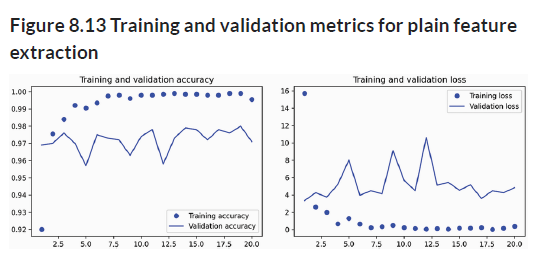

### 8.22 繪製結果

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

我們達到了大約 97% 的驗證準確率 比我們在上一節中訓練的小模型所達到的要好得多

頭開始。然而，這有點不公平，因為 ImageNet 包含許多狗和貓的實
 
例，這意味著我們的預訓練模型已經擁有手頭任務所需的確切知識。當您使用預訓練功能時，情況並非總是如此。


然而，這些圖也表明我們幾乎從一開始就過度擬合 儘管使用了相當大的 dropout。
這是因為這種技術不使用數據增強，這對於防止對小型圖像數據集的過
度擬合至關重要。

特徵提取和數據增強

現在讓我們回顧一下我提到的用於進行特徵提取的第二種技術，它更慢且更昂貴，但它允許我們在訓練期間使用數據增強：創建一個模型，將conv_base與一個新的密集分類器鏈接起來，並訓練它結束在輸入端結束。

為了做到這一點，我們將首先凍結卷積基。
凍結一層或一組層意味著防止它們的權重在訓練期間被更新。如果我們不這樣做，卷積基先前學習的表示將在訓練期間被修改。因為頂部的密集層是隨機初始化的，所以非常大的權重更新將通過網絡傳播，有效地破壞了先前學習的表示。


在 Keras 中，我們通過將其可訓練屬性設置為False來凍結層
或模型


### 8.23 實例化和凍結 VGG16 卷積基

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

將trainable設置為False會清空層或模型的可訓練權重列表。

In [ ]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

In [ ]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

現在我們可以創建一個鏈接在一起的新模型


1.數據增強階段 2. 我們的凍結卷積基礎
3.密集分類器


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

通過這種設置，只有我們添加的兩個Dense層的權重會被訓練。總共有四個權重張量：每層兩個（主權重矩陣和偏置向量）。請注意，為了使這些更改生效，您必須首先編譯模型。如果您在編譯後修改了權重可訓練性，則應重新編譯模型，否則這些更改將被忽略。

讓我們訓練我們的模型。由於數據增強，模型開始過度擬合需要更長的時間，所以我們可以訓練更多的 epoch 讓我們做 50 個。

這種技術非常昂貴，只有在您可以使用 GPU（例如 Colab 中提供的免費 GPU）時才應該嘗試它  它在 CPU 上是難以處理的。如果你不能在 GPU 上運行你的代碼，那麼前面的技術就是去。


In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

讓我們再次繪製結果（見圖 8.14）。如您所見，我們達到了超過 98% 的驗證準確率。這比以前的模型有了很大的改進。

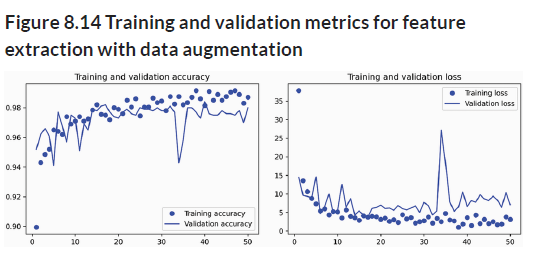

讓我們檢查一下測試的準確性。

### 8.26 在測試集上評估模型

In [ ]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

我們得到了 97.5% 的測試準確率。與之前的測試準確
性相比，這只是一個適度的改進，鑑於驗證數據的強勁結果，這有點令人失望。
模型的準確性始終取決於您評估它的樣本集！一些樣本集可能比其他樣本集更難，並且在一個集上的強大結果不一定會完全轉化為所有其他集。


## 8.3.2	微調預訓練模型

與特徵提取互補的另一種廣泛使用的模型重用技術是微調（見圖
8.15）。微調包括解凍用於特徵提取的凍結模型庫的幾個頂層，並 聯合訓練模型的新添加部分（在本例中為全連接分類器）和這些頂 層。這被稱為微調，因為它會稍微調整被重用模型的更抽象的表示， 以使它們與手頭的問題更相關。


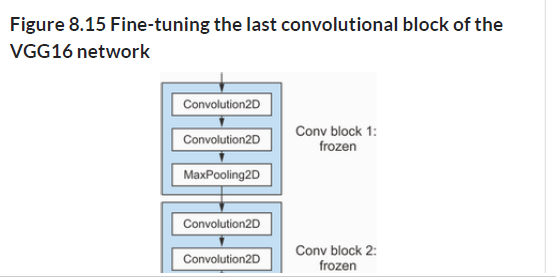

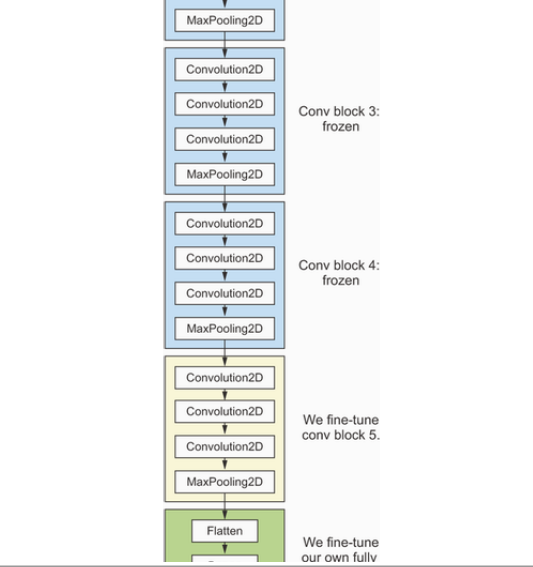

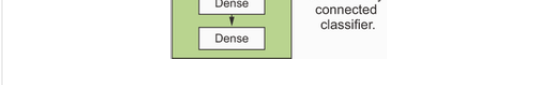

我之前說過，有必要凍結 VGG16 的捲積基礎，以便能夠在上面訓練一個隨機初始化的分類器。出於同樣的原因，只有在頂部的分類器已經被訓練後，才可能微調卷積基礎的頂層。如果分類器還沒有經過訓練，那麼在訓練期間通過網絡傳播的誤差信號 將太大，並且先前由被微調的層學習的表示將被破壞。因此，微調網絡的步驟如下：

1.	在已經訓練好的基礎網絡之上添加我們的自定義網絡。


2.	凍結基礎網絡。
3.	訓練我們添加的部分。

你不應該解凍“批量標準化”層， 這在這裡不相關，因為沒有這樣的
VGG16 中的層。批量標準化及其對微調將在下一章中解釋。）
5. 聯合訓練這兩個層和我們添加的部分。


您在做功能時已經完成了前三個步驟
萃取。讓我們繼續第 4 步：我們將解凍我們的conv_base然後凍結其中的各個層。


提醒一下，這就是我們的捲積基礎的樣子：


In [ ]:
conv_base.summary()

我們將微調最後三個卷積層，這意味著
直到block4_pool的所有層都應該被凍結，並且這些層
 
block5_conv1 可訓練。
 
, block5_conv2
 
, 和block5_conv3應該是
 



為什麼不微調更多層？為什麼不微調整個卷積基礎？你可以。但是你需要考慮
下列的：

卷積基礎中的較早層編碼更通用、可重用的特徵，而更高層編碼更專業的特徵。微調更專業的功能更有用，因為這些功能需要重新用於您的新問題。微調較低層的回報將快速下降。
訓練的參數越多，過度擬合的風險就越大。卷積基礎有1500 萬個參數，因此嘗試在您的小型數據集上訓練它是有風險的。


因此，在這種情況下，只微調卷積基礎中的前兩層或三層是一個很好的策略。讓我們從上一個示例中停止的地方開始進行設置。


### 8.27 凍結所有層直到倒數第四個

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

現在我們可以開始微調模型了。我們將使用 RMSprop 優化器執行此操作，使用非常低的學習率。使用低學習率的原因是我們希望限制對我們正在微調的三層表示的修改幅度。太大的更新可能會損害這些表示。

### 8.28 微調模型

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

我們最終可以在測試數據上評估這個模型：

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

在這裡，我們得到了 98.5% 的測試準確率（同樣，您自己的結果可能在一
個百分點之內）。在圍繞這個數據集的最初的 Kaggle 比賽中，這將是最
好的結果之一。然而，這並不是一個公平的比較，因為我們使用了預訓練的特徵，這些特徵已經包含了關於貓和狗的先驗知識，而競爭對手當時無法使用這些知識。


從積極的方面來說，通過利用現代深度學習技術，我們只使用了可用 於比賽的一小部分訓練數據（大約 10%）就達到了這個結果。能夠訓練 20,000 個樣本與 2,000 個樣本之間存在巨大差異！
現在，您擁有一套可靠的工具來處理圖像分類問題，尤其是處理小型數據集。

概括
 
Machine Translated by Google
 
卷積網絡是計算機視覺任務的最佳機器學習模型類型。即使在非常小的數據集上也可以從頭開始訓練，並獲得不錯的結果。

Convnets 通過學習模塊化模式和概念的層次結構來表示視覺世界。
在小數據集上，過度擬合將是主要問題。
在處理圖像數據時，數據增強是一種對抗過度擬合的有效方法。
通過特徵提取可以很容易地在新數據集上重用現有的
捲積網絡。這是處理小型圖像數據集的一項有價值的技術。
作為特徵提取的補充，您可以使用微調，它可以適應
新問題，即現有模型先前學習的一些表示。這進一步推動了性能。

 
使用 liveProject 自己構建它！
使用 AutoKeras 進行圖像分類 ‑ 項目 1：基礎深度

您想了解如何使用深度學習對圖像進行分類嗎？獲取這個免費的相關 liveProject，並成為執行任務的機器學習應用科學家的角色。

網站地圖
接下來上...
9	計算機視覺的高級深度學習
計算機視覺的不同分支：圖像分類、圖像分割、目標檢測


現代卷積網絡架構模式：殘差連接、批量歸一化、深度可分離卷積
可視化和解釋卷積網絡所學內容的技術
